In [1]:
import IsoDAT2D as iso
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import SimDAT2D as sim
import os

In [2]:
os.chdir(r'/blue/mbutala/dalverson/mask_job')

In [21]:
data = pd.read_csv('integrations_more.csv')

In [22]:
len(data)

1000

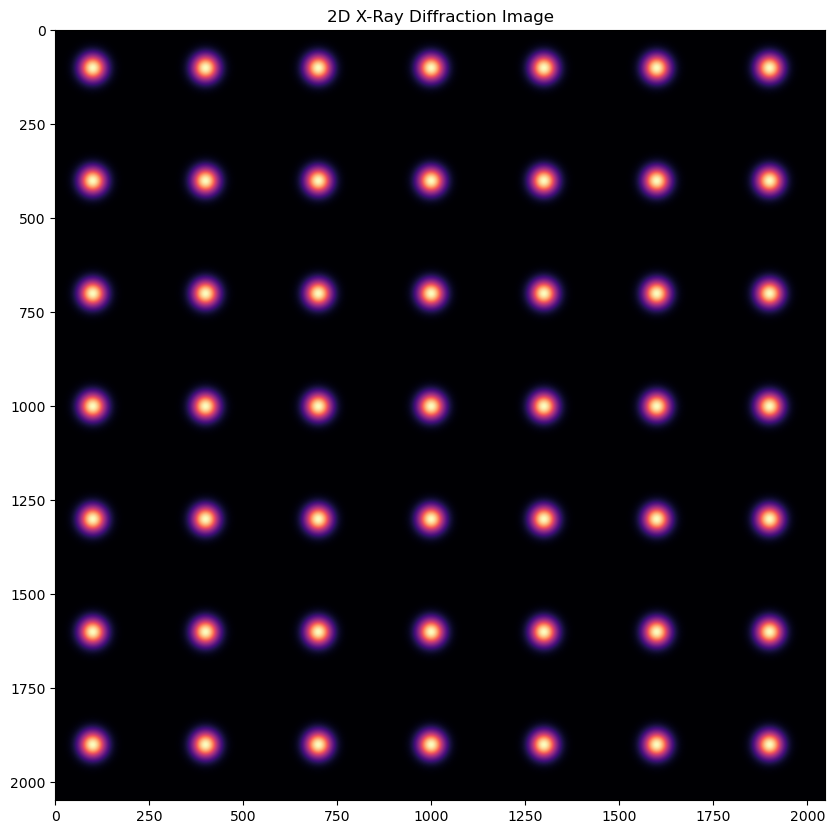

Select calibrant:
1. AgBh
2. Al
3. alpha_Al2O3
4. Au
5. C14H30O
6. CeO2
7. Cr2O3
8. cristobaltite
9. CrOx
10. CuO
11. hydrocerussite
12. LaB6
13. LaB6_SRM660a
14. LaB6_SRM660b
15. LaB6_SRM660c
16. mock
17. NaCl
18. Ni
19. PBBA
20. Pt
21. quartz
22. Si
23. Si_SRM640
24. Si_SRM640a
25. Si_SRM640b
26. Si_SRM640c
27. Si_SRM640d
28. Si_SRM640e
29. TiO2
30. ZnO
Si_SRM640e


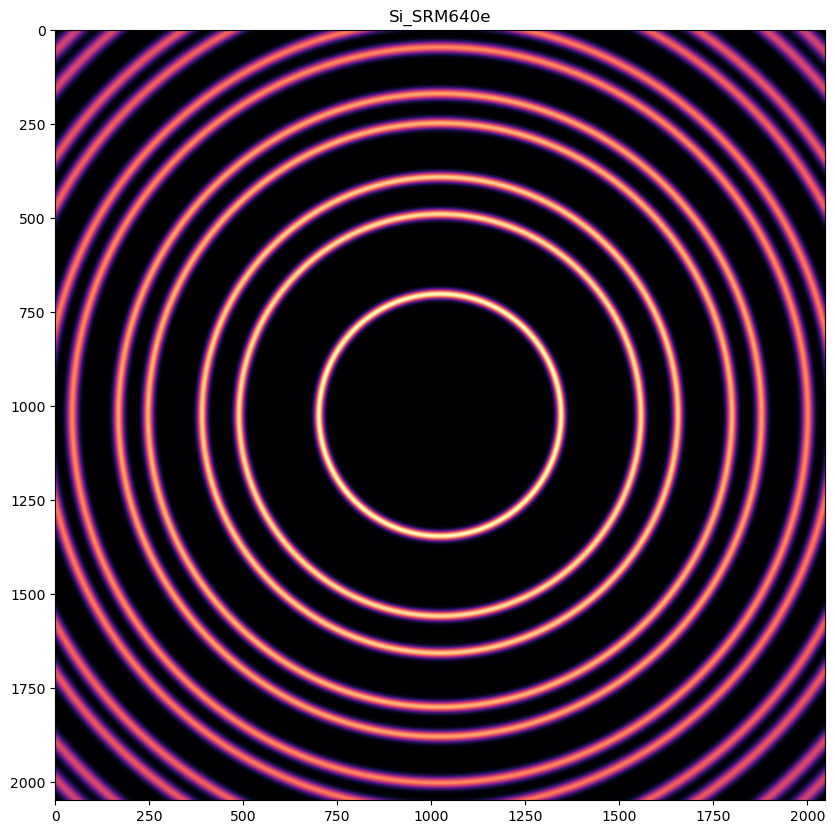

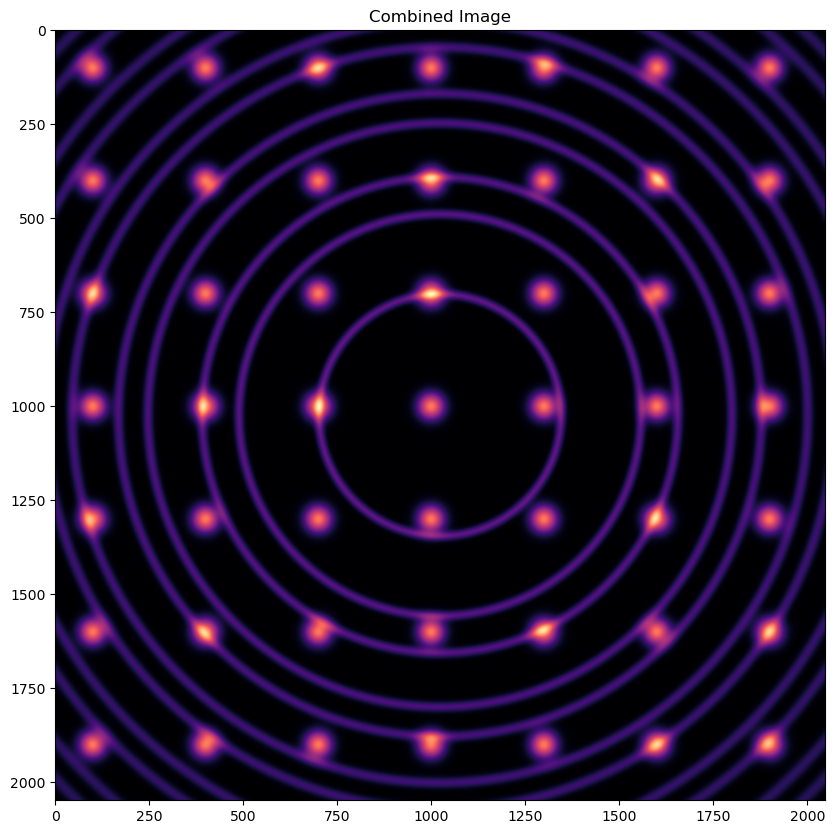

In [9]:
#Creating spot image
spots = sim.create_anisotropic(10, 25, 300, size = 200, cmap = 'magma')
spots = spots*5
pattern = sim.create_isotropic(.4, .5e-10, cmap = "magma" )
pattern = pattern*2
thin_film = sim.combine_image(pattern, spots, cmap = "magma")

In [ ]:
q, int = sim.integreate_image()

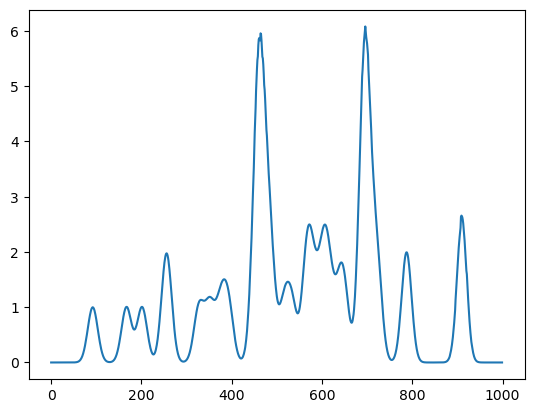

In [5]:
plt.figure()
plt.plot(data[0])

In [6]:
data = pd.DataFrame(data)

In [8]:
data_new = data[0:24]

In [8]:
import IsoDAT2D as iso
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from sklearn.decomposition import NMF
import dask
import glob as glob
from tifffile import imread, imshow
import warnings
import dask
import pickle 
from dask.distributed import Client, as_completed, get_worker

def attempt(Real_Data, Length, i, init= None, solver = 'cd', beta_loss = 'frobenius', iter = 500):
    NMF_model = NMF(n_components=i, init = init, solver = solver, beta_loss = beta_loss, max_iter = iter)
    NMF_data= NMF_model.fit_transform(Real_Data)
    fit_compos = NMF_model.components_
    Q = np.array(NMF_model.reconstruction_err_)*100
    warnings.filterwarnings("ignore", category=FutureWarning)
    return Q

def attempt2(Real_Data, Length, i, init= None, solver = 'cd', beta_loss = 'frobenius', iter = 500):
    NMF_model = NMF(n_components=i, init = init, solver = solver, beta_loss = beta_loss, max_iter = iter)
    NMF_data= NMF_model.fit_transform(Real_Data)
    fit_compos = NMF_model.components_
    Q = np.array(NMF_model.reconstruction_err_)*100
    warnings.filterwarnings("ignore", category=FutureWarning)
    return Q, fit_compos, NMF_data


def Run_NMF(Real_Data, init= None, solver = 'cd', beta_loss = 'frobenius', itear = 1000, show = False):
    
    """" Comparison of multiple components without manually comparing
    multiple components all at once. There are a few ways that this can be done. One way
    is to take the residuals of the datasets with themselves to see which is the closests to the 
    "correct" component. This may only be done on sample data potentially. Could include a 
    simulated dataset of what the standing component should look like give or take some 
    variations in the data. When the residuals are taken if it is less than some given 
    percentage the would be the dataset/NMF component to use further. There may be multiple
    thus having to go in manually to find differences. 
    
    To do this, will need to import the simulated XRD pattern from VESTA and then take the residual differences
    of each component and compared to the simulated pattern. Will have the program spit out the compnents that
    meet the cutoff. """

    In = init
    Solve = solver
    Beta = beta_loss
    It = itear
    #client = Client()

    #def callback(future):
       #worker = get_worker()
        #job_id = future.key[1]
        #print(f"Processing job {job_id} on worker {worker.name}")
        
        # Define delayed computations
    #delayed_jobs = [dask.delayed(attempt)(Real_Data, Real_Data.shape[1], i, In, Solve, Beta, It) for i in range(1, Real_Data.shape[1])]
    # Compute the results
    #calcs = dask.compute(*delayed_jobs)[0]

# Compute delayed computations and register the callback
   # for future in as_completed(delayed_jobs, with_results=False):
       # future.add_done_callback(callback)

    # Define delayed computations
    #delayed_jobs = [dask.delayed(attempt)(Real_Data, Real_Data.shape[1], i, In, Solve, Beta, It) for i in range(1, Real_Data.shape[1])]

# Compute the delayed computations to get futures
    #futures = dask.compute(delayed_jobs, scheduler=client)[0]

# Register the callback
    #as_completed(futures, with_results=False).add_done_callback(callback)

# Compute results
    #calcs = dask.compute(futures, scheduler=client)[0]

    #jobs = [dask.delayed(attempt)(Real_Data, Real_Data.shape[1], i, In, Solve, Beta, It) for i in range(1, Real_Data.shape[1])]
    #jobs = [dask.delayed(attempt)(Real_Data, Real_Data.shape[1], i, In, Solve, Beta, It) for i in range(1,20)]
    #calcs = dask.compute(jobs)[0]

    calcs = []
    
    for i in range(1, Real_Data.shape[1]):
        calcs.append(attempt(Real_Data, Real_Data.shape[1], i, In, Solve, Beta, It))
        print('The beta-divergence for', i, 'components is', calcs[i-1], '%\n')
        print(f'Completed {i} out of {Real_Data.shape[1]}')
        
    calcs = np.array(calcs)
    min_Q = np.min(calcs)
    noc = np.where(calcs == min_Q)
    noc_2 = noc[0]
    number_of_components = noc_2[0] +1

    Divergence, compos, NMF_Data_2 = attempt2(Real_Data, Real_Data.shape[1], number_of_components, In, Solve, Beta)
            
    
    print('The beta-divergence is: ', Divergence, '%\n','The final number of components used were',number_of_components+1, '\n') 
    
    
    m = pd.DataFrame(compos)
    m = m.T
    
    if show == True:
        plt.figure(figsize = (5,5))
        colors = plt.cm.magma(np.linspace(0,1, number_of_components))
        i = 0
        while i < number_of_components:
            plt.plot(m[i], c = colors[i], alpha = 0.7)
            i = i+1
    
    return m,NMF_Data_2, min_Q

def AggCluster(Number_Clusters, data):
    
    """A program that will take in the type of scikitlearn clustering algorithm
        desired and the number of clusters as well as the data in a numpy array
        and output the associated clusters with the original data. This will make
        the 'latent' space from the clustering algorithms have more meaning"""

    from sklearn.cluster import AgglomerativeClustering
    Make_Clusters= AgglomerativeClustering(n_clusters = Number_Clusters, compute_distances=True)
    y_kmeans = Make_Clusters.fit_predict(data)
    information = Make_Clusters.fit(data)
    parameter = information.distances_
    
    x = 0
    Understanding_data = {"Cluster_Number":[], "Int_Angle":[]}
    while x < len(data):
        Understanding_data["Cluster_Number"].append(y_kmeans[x])
        Understanding_data["Int_Angle"].append(data[x])
        x = x + 1

    # Create a dictionary to store data points for each cluster
    cluster_data = {}
    for q in range(Number_Clusters):
        cluster_data[q] = []

    for i in range(len(data)):
        cluster_num = Understanding_data["Cluster_Number"][i]
        data_point = Understanding_data["Int_Angle"][i]
        cluster_data[cluster_num].append(data_point)

# Now cluster_data contains lists of data points for each cluster


    # x = 0
    # Understanding_data = {"Cluster_Number":[], "Int_Angle":[]};
    # while x < len(data):
    #     Understanding_data["Cluster_Number"].append(y_kmeans[x])
    #     Understanding_data["Int_Angle"].append(data[x])
    #     x = x+1
        
    # # Create an empty list to store the data
    # data_list = []
    
        
    # q = 0
    # while q < Number_Clusters:
    #     z = 0
    #     plt.figure(figsize=(5,5))
    #     plt.xlabel('X')
    #     plt.ylabel('Y')
    #     plt.title('Agglomerative Clustering'+' ' +str(q))

    #     while z < len(data):
    #         if Understanding_data["Cluster_Number"][z] == q:
    #             plt.plot(Understanding_data["Int_Angle"][z], label = 'Component'+str(z))
    #         z = z+1
    
    #      #Check if the plot looks good if the plot looks good, append the data to the list
    #     #plt.show(block = False)
    #     #plt.pause(0.1)
        
    #     #if input("Do the identified components look like an isotropic scattering signal? (y/n)") == 'y':
    #     i = 0
    #     while i < len(data):
    #         if Understanding_data["Cluster_Number"][i] == q:
    #             data_list.append(Understanding_data["Int_Angle"][i])
    #         i = i+1
                
    #     q = q+1
    #with open('first_round_submission.pkl', 'wb') as f:
       # pickle.dump(Understanding_data, f)
    
    return Understanding_data, cluster_data


def smooth_components(Identified_components, filter_strength = 2, show = False):
    '''A function that will smooth the components identified from the agglomerative clustering algorithm'''
    
    # Importing required library
    from scipy.signal import savgol_filter
    
    # Defining a dictionary that maps filter strength to the number of points for the smoothing window
    strength_to_points = {1: 3, 2: 5, 3: 7, 4: 11, 5: 15}
    
    # Retrieving the number of points for the smoothing window based on the filter strength provided
    points = strength_to_points.get(filter_strength)

    # Applying Savitzky-Golay filter to smooth the identified components by taking their average along the columns
    smoothed_compos = savgol_filter(np.mean(Identified_components, axis = 0), points, 1)
    
    # If show argument is True, plotting the original components, their average, and the smoothed components
    if show == True:
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
        ax1.plot(Identified_components.T, c = 'k', linewidth = 2, alpha = 0.7)
        ax1.set_title('Identified Components')
        ax1.set_ylabel('Intensity')
        ax2.plot(np.mean(Identified_components, axis = 0), c = 'r', linewidth = 2, alpha = 0.7)
        ax2.set_ylabel('Intensity')
        ax2.set_title('Mean of Identified Components')
        ax3.plot(smoothed_compos, c = 'g', linewidth = 2, alpha = 0.7, label = 'Smoothed Component')
        ax3.scatter(np.arange(len(np.mean(Identified_components, axis = 0))), np.mean(Identified_components, axis = 0), c = 'r', s = 10, 
                    label = 'Mean Component')
        ax3.set_xlabel('Data Points')
        ax3.set_title('Smoothed Component')
        ax3.set_ylabel('Intensity')
        ax3.legend()
    
    # Returning the smoothed components
    return smoothed_compos

def run_nmfac(Data, initialize_iter = 0, clusters = 5):
    """A function that will run the NMF algorithm and then cluster with agglomerative clustering the components and returns the 
        identified components for later PDF analysis. The function starts with a random initializer
        that will be used to initialize the NMF algorithm. The user can decide how many iterations the 
        initializer takes. Then it will go through the NMF algorithm and compare the beta divergences of all the
        initializations and select the one with the lowest. By default, there is no initializer and the NMF algorithm
        uses preset parameters to run the algorithm. """
        
        #NMF Parameter Values
        
    import warnings
    warnings.filterwarnings("ignore")
    
    
    init_params = ['random', 'nndsvd', 'nndsvda', 'nndsvdar']
    solver_params = ['cd', 'mu']
    beta_loss_params = ['frobenius', 'kullback-leibler']
    tol_params = np.arange(0.00001, 0.01, 0.0001)
    max_iter_params = np.arange(100, 10000, 100)
    shuffle_params = [True, False]
        
    #When random initializers are not wanted
    if initialize_iter == 0:
        weights, components, beta = Run_NMF(Data, show = True)
        AggComponents = np.array(components).T
        Dictionary, found_compos = AggCluster(clusters, AggComponents)
        
        found_compos = np.array(found_compos)
        
    elif initialize_iter > 0:
        beta_div = []
        
        init_for_init = np.random.choice(init_params,initialize_iter)
        solver_for_init = np.random.choice(solver_params, initialize_iter)
        beta_loss_for_init = np.random.choice(beta_loss_params, initialize_iter)
        tol_for_init = np.random.choice(tol_params, initialize_iter)
        max_iter_for_init = np.random.choice(max_iter_params, initialize_iter)
        shuffle_for_init = np.random.choice(shuffle_params, initialize_iter)
        
        for i in range(initialize_iter):
            
            if beta_loss_for_init[i] == 'kullback-leibler':
                solver_for_init[i] = 'mu'
                
            print('The parameters selected for run' + str([i]) + ' are ' + str(init_for_init[i]) + ', ' + str(solver_for_init[i]) + ', ' + str(beta_loss_for_init[i]) + ', ' + str(tol_for_init[i]) + ', ' + str(max_iter_for_init[i]) + ', ' + str(shuffle_for_init[i]) + '. \n' )
            weights, components, beta = Run_NMF(Data, init = init_for_init[i], solver = solver_for_init[i], 
                                                beta_loss = beta_loss_for_init[i], itear = max_iter_for_init[i], show = False)
            
            beta_div.append(beta)
        beta_np = np.array(beta_div)
        good_init = np.argmin(beta_np)
        
        weights, components, beta = Run_NMF(Data, show = True, init = init_for_init[good_init], solver = solver_for_init[good_init], beta_loss=beta_loss_for_init[good_init],
                                             itear = max_iter_for_init[good_init])
        
        AggComponents = np.array(components).T
        Dictionary, found_compos = AggCluster(clusters, AggComponents)
        
    found_compos = np.array(found_compos)
            
        
    return Dictionary, found_compos

The beta-divergence for 1 components is 9551.036313184715 %

Completed 1 out of 64
The beta-divergence for 2 components is 6742.529216695377 %

Completed 2 out of 64
The beta-divergence for 3 components is 3545.8121539455624 %

Completed 3 out of 64
The beta-divergence for 4 components is 85.09714370558859 %

Completed 4 out of 64
The beta-divergence for 5 components is 157.45350474306582 %

Completed 5 out of 64
The beta-divergence for 6 components is 51.32423613747513 %

Completed 6 out of 64
The beta-divergence for 7 components is 30.453766987863006 %

Completed 7 out of 64
The beta-divergence for 8 components is 24.034354944914828 %

Completed 8 out of 64
The beta-divergence for 9 components is 17.645229822009085 %

Completed 9 out of 64
The beta-divergence for 10 components is 4.94665737659004e-05 %

Completed 10 out of 64
The beta-divergence for 11 components is 4.9552460675533164e-05 %

Completed 11 out of 64
The beta-divergence for 12 components is 0.00010221303450379143 %

Com

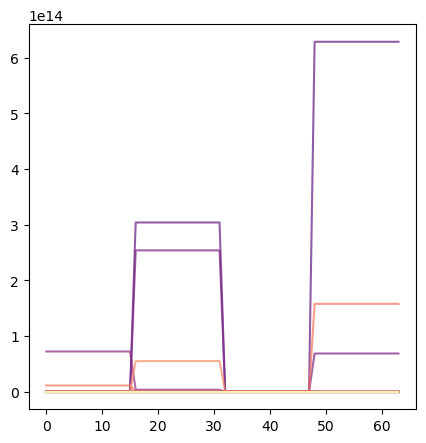

In [10]:
my_dict, my_comps = run_nmfac(data, clusters = 5)

Add print statements to the code to know what it is doing

In [11]:
my_dict

{'Cluster_Number': [0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 1],
 'Int_Angle': [array([2.31611453e-03, 2.26403552e-03, 2.60699678e-03, 2.74357721e-03,
         2.84550522e-03, 2.90310856e-03, 3.01605082e-03, 3.11550333e-03,
         3.27193029e-03, 3.43120889e-03, 3.58132044e-03, 3.61190715e-03,
         3.73223663e-03, 3.90434425e-03, 4.65816315e-03, 4.77389151e-03,
         4.67247236e-03, 4.80522831e-03, 4.78527808e-03, 4.63172110e-03,
         4.63152246e-03, 4.52368504e-03, 4.34905717e-03, 4.24551363e-03,
         4.59675157e-03, 4.76948283e-03, 4.45928617e-03, 4.16787681e-03,
         3.99058713e-03, 3.78516553e-03, 3.49891391e-03, 3.21498890e-03,
         2.97393686e-03, 2.69681637e-03, 2.63093587e-03, 2.59801407e-03,
         2.36034829e-03, 2.08567961e-03, 1.85261162e-03, 1.64922983e-03,
         1.42783027e-03, 1.25937696e-03, 1.07969787e-03, 9.57050709e-04,
         8.46281868e-04, 7.99858449e-04, 6.81636859e-04, 5.69609424e-04,
         4.80489384e-04, 4.06027915e

In [13]:
cluster_groups = {}
for cluster_num in set(my_dict['Cluster_Number']):
    cluster_groups[cluster_num] = []

# Group the data based on cluster numbers
for cluster_num, int_angle in zip(my_dict['Cluster_Number'], my_dict['Int_Angle']):
    cluster_groups[cluster_num].append(int_angle)

In [19]:
z = pd.DataFrame(cluster_groups[0])

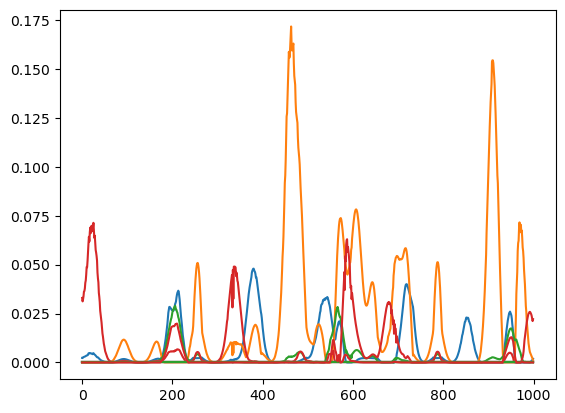

In [20]:
plt.plot(z.T)